In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')

In [3]:
import numpy as np

dim=225
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
A=np.asmatrix(A)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 225 dim problem.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-02 13:48:27 [INFO] <ipython-input-4-26a6584d83b0> 2 - Benchmark 225 dim problem.


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)

@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,Err_list,ProbCount,restart,debug,refine,blist,reslist,IterErrList10,GmresRunTime):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *




Err_list=[]
IterErrList10=[]
GmresRunTime=[]
GmresRunTimeOriginal=[]

NonML_Err_List=[]


debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    GmresRunTimeOriginal.append(run_time1)
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)

logger.info("Runtime of forward function is:")
logger.info(forwardTime_Total)



0
1
Final loss: 18184.74609375
parameters 101250
Initial Training
2
size 52
0.3835997665385363 0.31697411504851425
poor prediction,using initial x0
1.4036267139599659 0.8963290610117838 0.377075443283252 0.31619966082509493
1.4036267139599659 0.8963290610117838 0.377075443283252 0.31619966082509493
3
size 52
0.3431279902675466 0.377075443283252
1.3019806199590676 1.1676969394902699 0.3431279902675466 0.34702477916588315
1.3019806199590676 1.1676969394902699 0.3431279902675466 0.34702477916588315
4
size 52
0.3614318315051313 0.377075443283252
1.2425647670170292 1.2124581663132024 0.3614318315051313 0.3457258495331043
1.2425647670170292 1.2124581663132024 0.3614318315051313 0.3457258495331043
InnerProd [[1.         0.91328263 0.87171842]
 [0.91328263 1.         0.98743435]
 [0.87171842 0.98743435 1.        ]]
retraining
1
Final loss: 3722.73583984375
parameters 101250
5
size 52
0.3507498243452022 0.377075443283252
1.3637989190174267 1.3160573669786875 0.3507498243452022 0.360545088351976

2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 78 - Runtime of Non-decorated version is:
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 79 - 5005.230350412719
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 81 - Runtime of MLGMRES decorator is:
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 82 - 3358.818472040759
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 85 - Runtime of training (backprop) is:
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 86 - 393.9995842045755
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 88 - Runtime of forward function is:
2020-06-02 16:09:31 [INFO] <ipython-input-6-52369b08e8d8> 89 - 1.6394609638955444


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


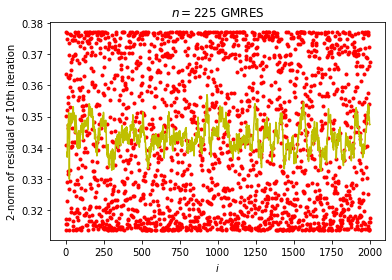

In [8]:
AVG=np.zeros((2000,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,2000)
for j in range(0,2000):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=225$ GMRES')
pp.savefig('GMRES.png')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


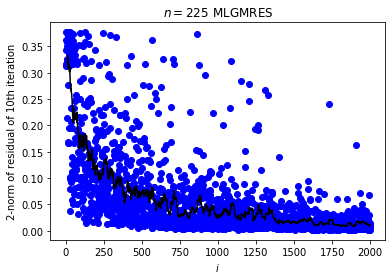

In [18]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((2000,1))
for j in range(0,2000):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
    
pp.plot(count,np.asarray(Err_Array_ML),'ob',count[10:-1],AVGML[10:-1],'k')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=225$ MLGMRES')
pp.savefig('MLGMRES.png')

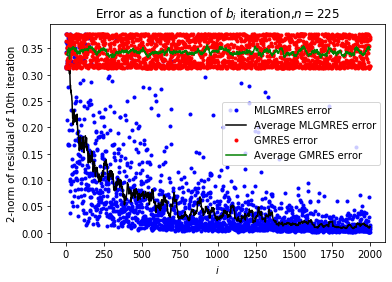

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration,$n=225$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


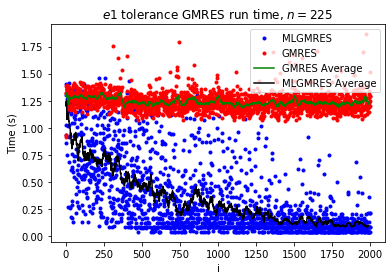

In [17]:
GmresRunTimeOriginal_AVG=np.zeros((2000,1))
Err_list_AVG=np.zeros((2000,1))


for j in range(0,2000):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,2000):
    Err_list_AVG[j]=moving_average(np.asarray(Err_list[:j]),j)
    
    
pp.plot(Err_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(Err_list_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=225$')
pp.legend(loc='best')
pp.savefig('Runtime.png')